In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.optim import lr_scheduler

import torchvision
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as transforms

from random import *
import os
import cv2
import copy
import time
from PIL import Image

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

In [3]:
data_dir = "../Data_Set/Resize_Crop_Data_1/"
image_datasets = {x: dset.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [4]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [5]:
print(dataset_sizes)
print(class_names)

{'train': 9924, 'val': 2505}
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '3', '4', '5', '6', '7', '8', '9']


## 모델 만들기

In [5]:
class customCNN(nn.Module):
    def __init__(self):
        super(customCNN, self).__init__()
        
        self.layer1 = self.conv_module(1, 16)
        self.layer3 = self.conv_module(16, 24)
        self.layer4 = self.conv_module(24, 32)
        self.layer5 = self.conv_module(32, 64)
        self.layer6 = self.conv_module(64,128)
        self.gap = self.global_avg_pool(128, 22)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.gap(out)
        out = out.view(-1, 22)

        return out
    
    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1)
        )
    
    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
model = customCNN()
model = model.cuda()
print(model)

customCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(32

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.1, patience=5)

## 모델 훈련

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=8):


    global_info = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=11, verbose=True)
    for epoch in range(num_epochs):
        local_info = []
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':

                model.train()
            else:

                model.eval()
                if epoch >0:
                    scheduler.step(val_loss)
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == 'val':
                val_loss = running_loss / dataset_sizes['val']
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)
            else:
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        lr_get = get_lr(optimizer)
        print("Current learning rate : {:.8f}".format(lr_get))
        global_info.append(local_info)
        if phase =='val':
            early_stopping(epoch_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [11]:
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/99
----------
train Loss: 2.7186 Acc: 0.3449
val Loss: 2.5145 Acc: 0.4379
Current learning rate : 0.00100000
Validation loss decreased (inf --> 2.514483).  Saving model ...
Epoch 1/99
----------
train Loss: 2.5541 Acc: 0.4379
val Loss: 2.3947 Acc: 0.4754
Current learning rate : 0.00100000
Validation loss decreased (2.514483 --> 2.394705).  Saving model ...
Epoch 2/99
----------
train Loss: 2.4446 Acc: 0.4735
val Loss: 2.2190 Acc: 0.5261
Current learning rate : 0.00100000
Validation loss decreased (2.394705 --> 2.219005).  Saving model ...
Epoch 3/99
----------
train Loss: 2.3420 Acc: 0.4971
val Loss: 2.1176 Acc: 0.5665
Current learning rate : 0.00100000
Validation loss decreased (2.219005 --> 2.117631).  Saving model ...
Epoch 4/99
----------
train Loss: 2.2488 Acc: 0.5258
val Loss: 2.0602 Acc: 0.5401
Current learning rate : 0.00100000
Validation loss decreased (2.117631 --> 2.060225).  Saving model ...
Epoch 5/99
----------
train Loss: 2.1565 Acc: 0.5552
val Loss: 1.9770 Acc: 

train Loss: 0.7080 Acc: 0.8747
val Loss: 0.5704 Acc: 0.8758
Current learning rate : 0.00100000
EarlyStopping counter: 1 out of 11
Epoch 49/99
----------
train Loss: 0.6895 Acc: 0.8786
val Loss: 0.5546 Acc: 0.8906
Current learning rate : 0.00100000
EarlyStopping counter: 2 out of 11
Epoch 50/99
----------
train Loss: 0.6878 Acc: 0.8807
val Loss: 0.5994 Acc: 0.8671
Current learning rate : 0.00100000
EarlyStopping counter: 3 out of 11
Epoch 51/99
----------
train Loss: 0.6785 Acc: 0.8778
val Loss: 0.5050 Acc: 0.9034
Current learning rate : 0.00100000
Validation loss decreased (0.538634 --> 0.504985).  Saving model ...
Epoch 52/99
----------
train Loss: 0.6650 Acc: 0.8832
val Loss: 0.5392 Acc: 0.8838
Current learning rate : 0.00100000
EarlyStopping counter: 1 out of 11
Epoch 53/99
----------
train Loss: 0.6625 Acc: 0.8802
val Loss: 0.5326 Acc: 0.8842
Current learning rate : 0.00100000
EarlyStopping counter: 2 out of 11
Epoch 54/99
----------
train Loss: 0.6507 Acc: 0.8839
val Loss: 0.6477 

In [13]:
torch.save(model, 'lotte_model.pt')

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

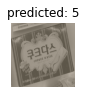

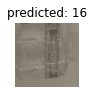

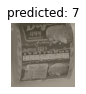

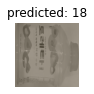

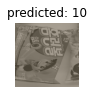

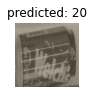

In [15]:
visualize_model(model_ft)

In [8]:
import natsort as nt
from PIL import Image
from torch.autograd import Variable 

def test_model():
    data_transforms = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    model_ft = torch.load('lotte_model.pt', map_location=device)
    path_test = "../Data_Set/Resize_Crop_Data_1/test"
    image_list = nt.natsorted(os.listdir(path_test))
    output_list = []
    for i, images in enumerate(image_list):
        path_test_image = os.path.join(path_test, images)
        image = Image.open(path_test_image)
        image = data_transforms(image)
        image.unsqueeze_(dim=0)
        image = Variable(image)
        image = image.cuda(device)
        torch.no_grad()
        output = model_ft(image)
        output = torch.argmax(output, dim=1)
        output_list.append(output)
        
    return output_list

output = test_model()

In [9]:
submission = pd.read_csv('submission.csv')
submission['label'] = torch.cat(output).detach().cpu().numpy()
submission.to_csv('../Data_Set/Resize_Crop_Data_1/submission.csv', index=False)

In [10]:
submission

,id,label
0,0_cidar.jpg,18
1,1_zec.jpg,14
2,2_buttering.jpg,10
3,3_welchs.jpg,13
4,4_toreta.jpg,10
...,...,...
5322,5322_welchs.jpg,13
5323,5323_squid_peanut.jpg,7
5324,5324_welchs.jpg,13
5325,5325_diget_choco.jpg,20


## 테스트 비교

In [11]:
answer = pd.read_csv("../Data_Set/Resize_Crop_Data_1/answer.csv")

In [12]:
answer

,id,label
0,0_cidar.jpg,4
1,1_zec.jpg,21
2,2_buttering.jpg,1
3,3_welchs.jpg,20
4,4_toreta.jpg,18
...,...,...
5322,5322_welchs.jpg,20
5323,5323_squid_peanut.jpg,15
5324,5324_welchs.jpg,20
5325,5325_diget_choco.jpg,8


In [13]:
cnt = 0
for label1, label2 in zip(submission['label'].values, answer['label'].values):
    if label1 == label2:
        cnt += 1

In [14]:
print(cnt)

384
